# Gradient operator demo

A concise demo that shows how to use `GradientOperator` on a simple function, compares the finite-difference result to the analytic derivative, and plots both.

In [6]:
# Imports and helpers
import numpy as np
import matplotlib.pyplot as plt
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.lebesgue_space import Lebesgue
from pygeoinf.interval.functions import Function
from pygeoinf.interval.operators import GradientOperator

# plotting defaults
plt.rcParams.update({'figure.figsize': (8, 4), 'font.size': 12})

In [7]:
# Domain/space and analytic functions
domain = IntervalDomain(0.0, 1.0)
space = Lebesgue(200, domain)

# Analytic function and derivative
def analytic_f(x):
    x = np.asarray(x)
    return np.sin(2 * np.pi * x)

def analytic_df(x):
    x = np.asarray(x)
    return 2 * np.pi * np.cos(2 * np.pi * x)

# Wrap as Function used by operators
f = Function(space, evaluate_callable=lambda x: analytic_f(x), name='sin')

# Points for plotting and comparison
xs = np.linspace(domain.a, domain.b, 400)

In [8]:
# Create gradient operator and compute numeric derivative
grad = GradientOperator(space, fd_order=4)

g = grad(f)

# Evaluate numeric and analytic derivatives on grid
num_df = g(xs)
ana_df = analytic_df(xs)

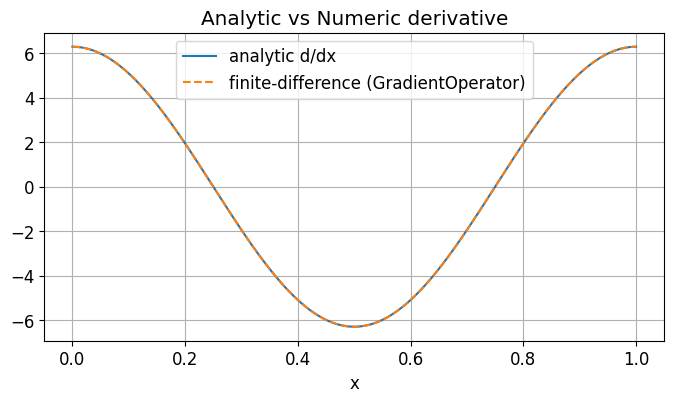

max abs error: 8.26822620121348e-05


In [9]:
# Visual comparison
plt.figure()
plt.plot(xs, ana_df, label='analytic d/dx')
plt.plot(xs, num_df, '--', label='finite-difference (GradientOperator)')
plt.legend()
plt.xlabel('x')
plt.title('Analytic vs Numeric derivative')
plt.grid(True)
plt.show()

# Print max absolute error
print('max abs error:', np.max(np.abs(num_df - ana_df)))

Notes:

- The `GradientOperator` uses finite differences by default. Set `fd_order` to 2 or 4 for different accuracy.
- For highest-fidelity comparisons, increase `space.dim` or reduce `fd_step` explicitly.

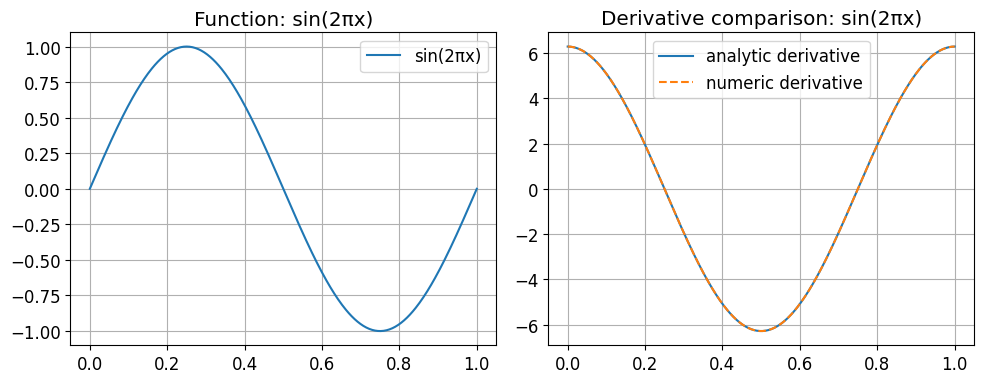

sin(2πx): max error = 8.268e-05, rms = 5.847e-06


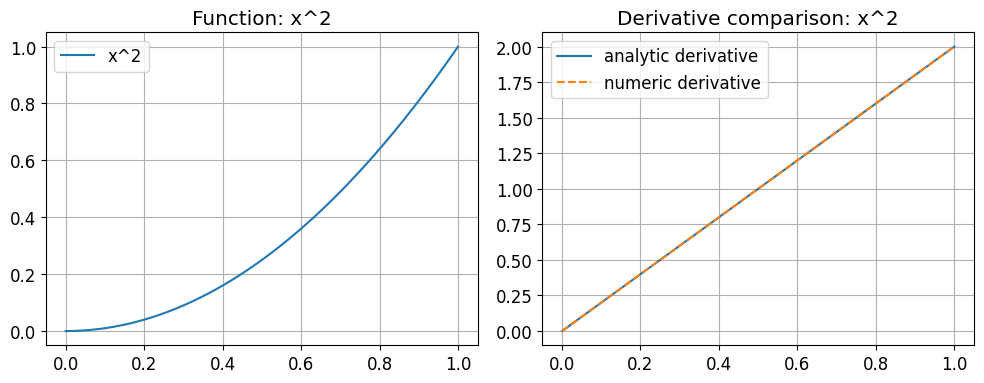

x^2: max error = 1.654e-13, rms = 2.848e-14


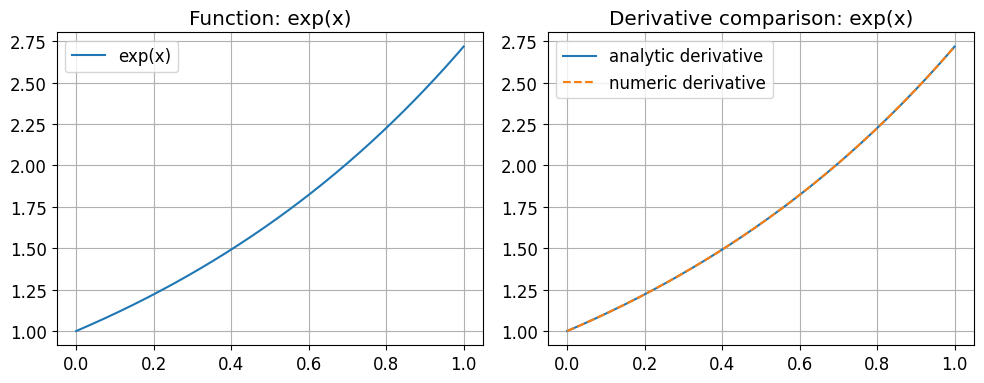

exp(x): max error = 9.054e-07, rms = 4.825e-08


In [10]:
# Simple functions + numeric derivative comparisons
import numpy as np
import matplotlib.pyplot as plt

# Define three simple analytic functions and their derivatives
def f1(x):
    return np.sin(2 * np.pi * x)
def df1(x):
    return 2 * np.pi * np.cos(2 * np.pi * x)

def f2(x):
    return x**2
def df2(x):
    return 2 * x

def f3(x):
    return np.exp(x)
def df3(x):
    return np.exp(x)

funcs = [(f1, df1, 'sin(2πx)'), (f2, df2, 'x^2'), (f3, df3, 'exp(x)')]

# Use the previously created Lebesgue space and GradientOperator object `grad` if present, else create fresh ones
try:
    grad
except NameError:
    from pygeoinf.interval.lebesgue_space import Lebesgue
    from pygeoinf.interval.operators import GradientOperator
    space = Lebesgue(200, domain)
    grad = GradientOperator(space, fd_order=4)

# Points for plotting
xs = np.linspace(domain.a, domain.b, 400)

for (f_callable, df_callable, label) in funcs:
    # wrap as Function on the same space so operator can accept it
    from pygeoinf.interval.functions import Function
    F = Function(space, evaluate_callable=lambda x, fun=f_callable: fun(x), name=label)

    # numeric derivative via GradientOperator
    G = grad(F)
    num_df = G(xs)
    ana_df = df_callable(xs)

    # Plot function and derivatives
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(xs, f_callable(xs), label=label)
    plt.title(f'Function: {label}')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(xs, ana_df, label='analytic derivative')
    plt.plot(xs, num_df, '--', label='numeric derivative')
    plt.title(f'Derivative comparison: {label}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print a simple error summary
    diff = num_df - ana_df
    print(f'{label}: max error = {np.max(np.abs(diff)):.3e}, rms = {np.sqrt(np.mean(diff**2)):.3e}')